# Load dependencies

In [1]:
from google.cloud import bigquery
import datetime
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook_connected"
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

In [2]:
client = bigquery.Client()

In [3]:
limits = 'LIMIT 15000'
limits = ''
sql_events = f"""
WITH geovisits_h3_indexes AS (
    SELECT *, `carto-os-eu`.h3.LONGLAT_ASH3(longitude, latitude, 10) h3_idx
    FROM `ggo-ppos-bqgis.singlespot.geovisits_paris_matview`
)
select sptId, uuid, latitude, longitude, accuracy, eventId,  
arrival, departure, score, rank, category, feature, placeName, h3_idx 
FROM geovisits_h3_indexes {limits}
"""

In [4]:
rows = client.query(sql_events).result()
df = rows.to_dataframe()
df.head()

,sptId,uuid,latitude,longitude,accuracy,eventId,arrival,departure,score,rank,category,feature,placeName,h3_idx
0,7d21b764-daae-4eb2-8330-a1fa6d0367af,9cf02c39-87ce-4865-9a6d-a46adb199ed3,48.824074,2.373960,48.0,84ea804206129a24f1075da79ffea90da8cc6796e42be0...,2021-07-14 10:34:34 +0200,2021-07-14 10:39:35 +0200,0.346496,1,amenity,veterinary,Obsèques Animales,8a1fb4646327fff
1,8a8f87c1-7dd0-4376-babc-455dd7c3b8b0,7cab399a-d75c-48b1-9c5c-1cb44e4ae337,48.840264,2.341110,42.0,5a5786eed2f59a4119137d0ac227be2f599b7a08ce0224...,2021-07-13 07:41:42 +0200,2021-07-13 09:44:50 +0200,0.512278,1,office,association,Communauté Chrétienne Universitaire,8a1fb4671ccffff
2,c6aa8b4f-857a-42e6-9093-3a6743eaf127,6b8927ca-e0c8-4979-b242-b4e12946a53d,48.880470,2.327291,57.0,938ca94e31e6c22fd016224e2fc845ceab87442c65a1ee...,2021-07-09 11:10:18 +0200,2021-07-09 11:32:37 +0200,0.821422,1,shop,model,Au Pullman,8a1fb4666c37fff
3,1d32bf1b-8694-4598-a569-773c6659303f,ac975d15-555a-4131-8f8d-f90268474e8f,48.844595,2.376132,48.0,f-5f82826cad9aa807265dc87f08a4ab9112faba8b,2021-07-08 17:46:16 +0200,2021-07-08 18:15:50 +0200,0.365783,1,tourism,artwork,None,8a1fb464410ffff
4,b8fbec5b-0de2-4383-9276-de5f22c6fe8d,0b518296-1a3c-4d18-bef8-8f15ed056fe8,48.884469,2.344850,48.0,5a2fa95268e830ecbdbe990a242f467a5c586b1c6c27d0...,2021-07-10 16:02:04 +0200,2021-07-10 17:10:15 +0200,0.565314,1,shop,fabric,Les Coupons de Saint-Pierre,8a1fb4666baffff


In [5]:
df['sptId'] = df['sptId'].astype(str)
df['category'] = df['category'].astype(str)
df['feature'] = df['feature'].astype(str)
df['arrival'] = pd.to_datetime(df['arrival'], format='%Y-%m-%d %H:%M:%S', utc=True)
df['depature'] = pd.to_datetime(df['departure'], format='%Y-%m-%d %H:%M:%S', utc=True)

In [6]:
df_w = pd.DataFrame(df[['h3_idx', 'category', 'feature', 'arrival']])
df_w['hour'] = df_w.arrival.dt.hour
df_w['day'] = df_w.arrival.dt.day
df_w['month'] = df_w.arrival.dt.month
df_w['year'] = df_w.arrival.dt.year
df_w['weekdayName'] = df_w.arrival.dt.day_name()
df_w['weekday'] = df_w.arrival.dt.day_of_week
df_w['week'] = df_w.arrival.dt.week
df_w['weekend'] = df_w.arrival.dt.day_of_week // 5 == 1
df_w['count'] = 1
df_w.head()


/var/folders/ld/xp2k58jx3wd1rl_mb_kg3pww0000gn/T/ipykernel_1948/4090829174.py:8: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.



,h3_idx,category,feature,arrival,hour,day,month,year,weekdayName,weekday,week,weekend,count
0,8a1fb4646327fff,amenity,veterinary,2021-07-14 08:34:34+00:00,8,14,7,2021,Wednesday,2,28,False,1
1,8a1fb4671ccffff,office,association,2021-07-13 05:41:42+00:00,5,13,7,2021,Tuesday,1,28,False,1
2,8a1fb4666c37fff,shop,model,2021-07-09 09:10:18+00:00,9,9,7,2021,Friday,4,27,False,1
3,8a1fb464410ffff,tourism,artwork,2021-07-08 15:46:16+00:00,15,8,7,2021,Thursday,3,27,False,1
4,8a1fb4666baffff,shop,fabric,2021-07-10 14:02:04+00:00,14,10,7,2021,Saturday,5,27,True,1


In [7]:
def plot_heatmap(df, title):
    plt.figure(figsize = (25, 8))
    ax = sns.heatmap(df, cmap='RdYlGn_r',
                    square=True,
                    fmt='.0f', annot=True,
                    linewidths=.1, annot_kws={'size':10},
                    cbar_kws={'shrink':.5, 'label':'Visits'})
    
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
    plt.title(title, fontdict={'fontsize':18}, pad=14)

In [8]:
all_weekday_hour_df = pd.pivot_table(df_w, values="count",index=["weekday"], columns=["hour"], aggfunc='sum', fill_value=0)
all_weekday_hour_df.head()

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
weekday,,,,,,,,,,,,,,,,,,,,,
0,138,58,65,98,364,818,1812,1976,1901,1935,...,2260,2406,2659,2297,1447,944,733,582,329,175
1,84,79,118,191,565,1161,2349,2261,1920,2000,...,2169,2482,2499,2109,1504,1020,720,629,423,266
2,187,144,107,184,358,558,779,1039,1393,1668,...,2161,2222,2190,1896,1455,1193,1125,1130,692,316
3,179,106,120,212,545,1105,2222,2326,2214,2165,...,2543,2719,2842,2575,1799,1229,995,894,520,303
4,182,108,147,254,604,1291,2688,2935,2856,3240,...,4029,4310,4330,3396,2384,1668,1220,1026,675,399


In [9]:
named_index = [[calendar.day_abbr[i] if isinstance(i, int) else i for i in list(all_weekday_hour_df.index)]] # name days
all_weekday_hour_df = all_weekday_hour_df.set_index(named_index)
all_weekday_hour_df.head()

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Mon,138,58,65,98,364,818,1812,1976,1901,1935,...,2260,2406,2659,2297,1447,944,733,582,329,175
Tue,84,79,118,191,565,1161,2349,2261,1920,2000,...,2169,2482,2499,2109,1504,1020,720,629,423,266
Wed,187,144,107,184,358,558,779,1039,1393,1668,...,2161,2222,2190,1896,1455,1193,1125,1130,692,316
Thu,179,106,120,212,545,1105,2222,2326,2214,2165,...,2543,2719,2842,2575,1799,1229,995,894,520,303
Fri,182,108,147,254,604,1291,2688,2935,2856,3240,...,4029,4310,4330,3396,2384,1668,1220,1026,675,399


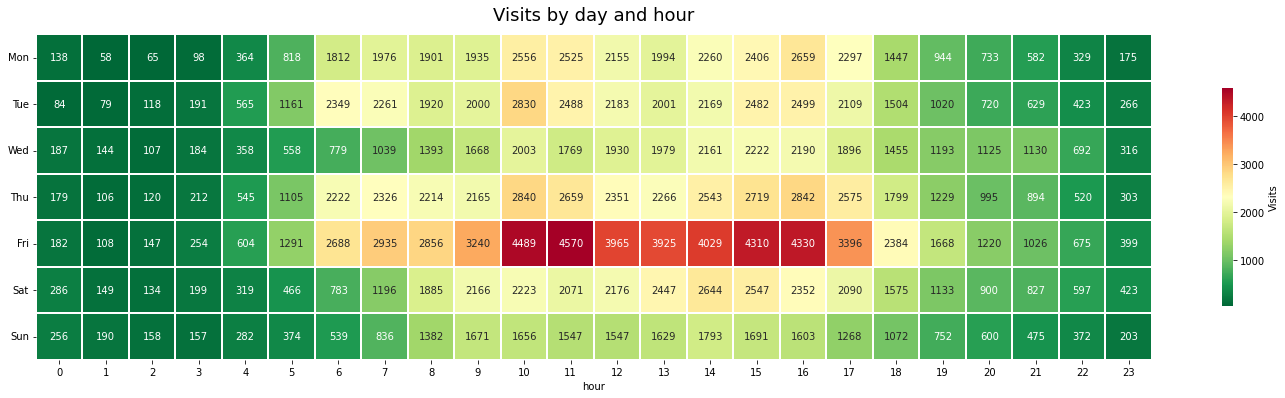

In [10]:
plot_heatmap(all_weekday_hour_df, 'Visits by day and hour')

In [ ]:
week_days_counts_df = df_w.groupby('weekday')['count'].agg(['sum']); #pd.pivot_table(df_w, values="count",index=["weekday"], columns=["hour"], aggfunc='sum', fill_value=0)
week_days_counts_df.head()

In [ ]:
week_days_counts_df.columns

In [ ]:
sns.lineplot(data=week_days_counts_df, x="weekday", y="sum")

In [ ]:
df_w['category'].unique()

In [ ]:
filtered_categories = ['amenity', 'shop', 'user']
df_w['category_2'] = np.where(df_w['category'].isin(filtered_categories), df_w['category'], 'others')
df_w['feature_2'] = np.where(df_w['category'].isin(filtered_categories), df_w['feature'], 'others')
df_w.head()
#amenities_shops[amenities_shops['category'] =='amenity']['feature'].unique()

In [ ]:
grouped_columns = ['category_2']

In [ ]:
h3_pivot = pd.DataFrame(pd.pivot_table(df_w,  columns=grouped_columns, index='h3_idx', values="count", aggfunc='sum', fill_value=0, margins = True, margins_name='total')).reset_index()
#h3_pivot.columns = h3_pivot.columns.map('_'.join).str.replace('len_', '')

h3_pivot.rename(columns={ h3_pivot.columns[0]: "h3_idx" }, inplace=True)
h3_pivot.head()

In [ ]:
from shapely.geometry import Polygon
from geojson.feature import *
import h3

In [ ]:
indexNames = h3_pivot[h3_pivot['h3_idx'] == 'total'].index

toto = h3_pivot.drop(indexNames)
toto.head()


In [ ]:
h3.compact(toto ['h3_idx'])

In [ ]:
indexNames = h3_pivot[h3_pivot['h3_idx'] == 'total'].index
h3_pivot.drop(indexNames, inplace=True)

In [ ]:
df_names = h3_pivot.columns
df_names = df_names[1:]
df_names

In [ ]:
h3_pivot_corr=h3_pivot[df_names]
correlations= h3_pivot_corr.corr()
mask = np.zeros_like(correlations)  # make mask
mask[np.triu_indices_from(mask)] = True  # mask the upper triangle
fig, ax = plt.subplots(figsize=(11, 9))  # create a figure and a subplot
cmap = sns.diverging_palette(220, 10, as_cmap=True)  # custom color map
"""
sns.heatmap(
    correlations,
    mask=mask,
    cmap=cmap,
    center=0,
    linewidth=0.5,
    cbar_kws={'shrink': 0.5}
)
"""
sns.heatmap(
    correlations,
    annot=True
)

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
indexNames = h3_pivot[h3_pivot['h3_idx'] == 'total'].index
h3_pivot.drop(indexNames, inplace=True)
X = h3_pivot.drop(['h3_idx','total'],axis=1)
y = h3_pivot['total']

In [ ]:
X.head()

In [ ]:
y.head()

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [ ]:
# Feature extraction
model = LogisticRegression()
rfe = RFE(model, 3)
fit = rfe.fit(X, y)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [ ]:
print(f"Training data - Features shape: {X_train.shape}")
print(f"Training data - Target shape: {y_train.shape}\n")
print(f"Test data - Features shape: {X_test.shape}")
print(f"Test data - Target shape: {y_test.shape}")

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
model0 = GradientBoostingClassifier(random_state=42)
model0.fit(X_train, y_train)
def get_roc_auc(model, X, y):
    y_proba = model.predict_proba(X)[:,1]
    return roc_auc_score(y, y_proba)
print(f"Training data - ROC AUC: {get_roc_auc(model0, X_train, y_train):.4f}")
print(f"Test data - ROC AUC: {get_roc_auc(model0, X_test, y_test):.4f}")

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [ ]:
pipeline = Pipeline([
    ('std_scalar', StandardScaler())
])
X_train= pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [ ]:
import hvplot.pandas

from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

In [ ]:
print(lin_reg.intercept_)

In [ ]:
pred = lin_reg.predict(X_test)

In [ ]:
pd.DataFrame({'True Values': y_test, 'Predicted Values': pred}).hvplot.scatter(x='True Values', y='Predicted Values')
pd.DataFrame({'Error Values': (y_test - pred)}).hvplot.kde()

In [ ]:
test_pred = lin_reg.predict(X_test)
train_pred = lin_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test, test_pred) , cross_val(LinearRegression())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

model = Sequential()

model.add(Dense(X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))

model.compile(optimizer=Adam(0.00001), loss='mse')

r = model.fit(X_train, y_train,
              validation_data=(X_test,y_test),
              batch_size=1,
              epochs=100)

In [ ]:
pd.DataFrame({'True Values': y_test, 'Predicted Values': pred}).hvplot.scatter(x='True Values', y='Predicted Values')
pd.DataFrame(r.history).hvplot.line(y=['loss', 'val_loss'])
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["Artficial Neural Network", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
results_df = results_df.append(results_df_2, ignore_index=True)

In [ ]:
results_df.set_index('Model', inplace=True)
results_df['R2 Square'].plot(kind='barh', figsize=(12, 8))